# Heightmaps

This notebook introduces surfaces parameterized by heightmaps.

In [2]:
# !pip install git+https://github.com/tum-pbs/PhiFlow@3.0
from phi.flow import *

Heightmaps can be used in 2D or 3D. They encode a grid surface made up of lines or planes, respectively.
The grid vertices are equally spaced and the displacement (height) of each point is specified via a 1D or 2D tensor.

The following code creates a heightmap in 2D from a list of height values.

<Figure size 864x360 with 1 Axes>

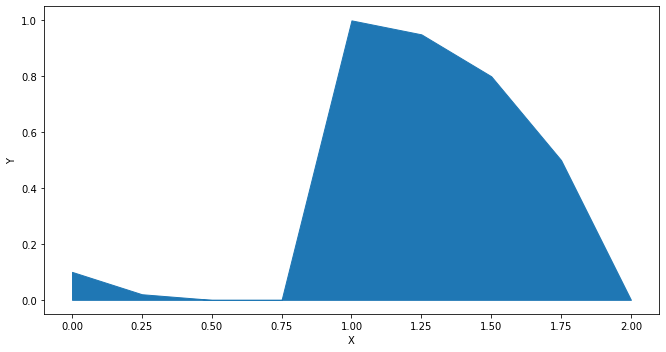

In [3]:
height = wrap([.1, .02, 0, 0, 1, .95, .8, .5, 0], spatial('x'))
bounds = Box(x=2, y=1)
heightmap = geom.Heightmap(height, bounds, max_dist=.1)
plot(heightmap)

The heightmap surface separates the inside from the outside.
Whether the inside is below or above the height values can be set in the `Heightmap` constructor.

<Figure size 864x360 with 2 Axes>

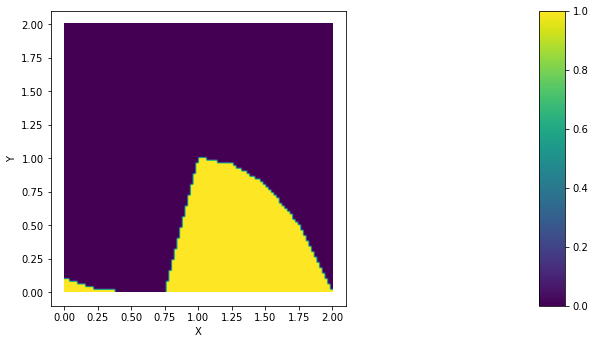

In [4]:
is_inside = CenteredGrid(lambda loc: heightmap.lies_inside(loc), x=100, y=100, bounds=Box(x=2, y=2))
plot(is_inside)

While the inside check is always exact, the distance from the surface is an approximation.
For small distances, the face directly underneath a point will usually be closest but for farther points this is not always true.
To account for this, each face links to one other face that will be queried for larger distances.
Finding these secondary faces is performed during heightmap construction where the parameter `max_dist` influences which other faces are the most important to link.

Above, we set `max_dist=0.1`. In the following cell, we visualize the distance from the surface.

C:\PhD\phiflow2\PhiML\phiml\backend\_backend.py:1582: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


<Figure size 864x360 with 2 Axes>

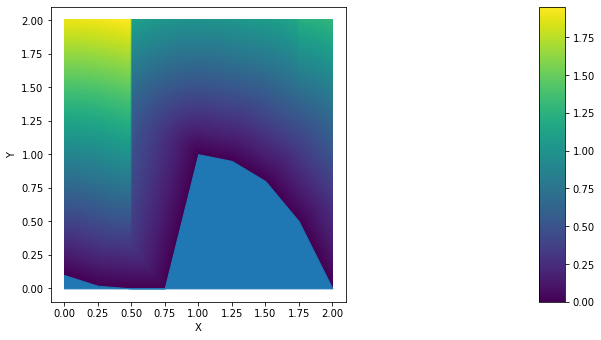

In [5]:
distance = CenteredGrid(lambda loc: heightmap.approximate_signed_distance(loc), x=100, y=100, bounds=Box(x=2, y=2))
plot(distance, heightmap, overlay='args')

With `max_dist=0.1`, the values further than 0.1 away from the cliff get inaccurate distances.
Let's increase `max_dist´ to see the difference.

<Figure size 864x360 with 2 Axes>

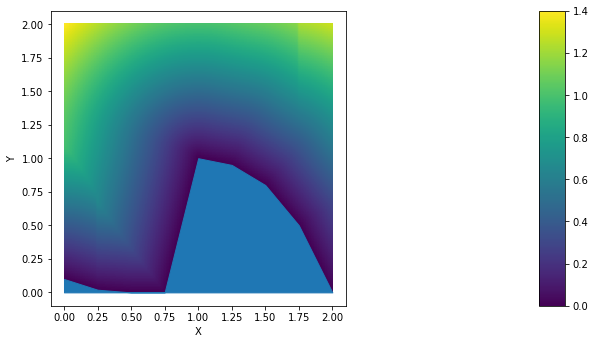

In [6]:
heightmap = geom.Heightmap(height, bounds, max_dist=1)
distance = CenteredGrid(lambda loc: heightmap.approximate_signed_distance(loc), x=100, y=100, bounds=Box(x=2, y=2))
plot(distance, heightmap, overlay='args')

Now larger distances are covered as well.
This runs with the same number of computations but trades off accuracy closer to the surface.

We can additionally query the direction to the closest surface point as well as the corresponding normal vector.

Let's plot these vectors for random points inside (orange) and outside (red) of the heightmap.

<Figure size 864x360 with 2 Axes>

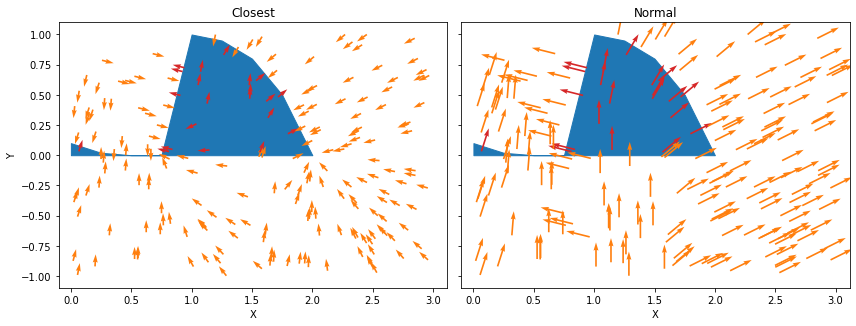

In [7]:
points = Box(x=3, y=(-1, 1)).sample_uniform(instance(points=200))
delta, normal, _, face_index = heightmap.approximate_closest_surface(points)
plot({'closest': [heightmap, PointCloud(points, .1 * math.vec_normalize(delta))],
      'normal': [heightmap, PointCloud(points, .2 * normal)]}, overlay='list', color=[0, heightmap.lies_inside(points)*2+1])

## Vertical Heightmaps

The grid orientation is determined by which spatial dimension is not part of the grid.
E.g. to create a vertical heightmap, the displacement values should be listed along the *y* direction.

<Figure size 864x360 with 1 Axes>

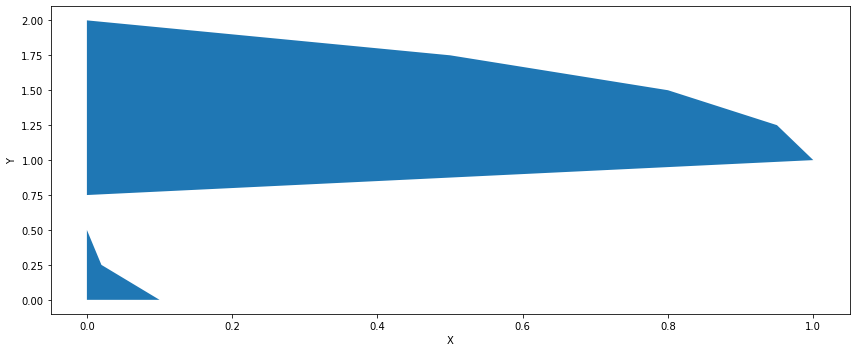

In [8]:
height = wrap([.1, .02, 0, 0, 1, .95, .8, .5, 0], spatial('y'))
bounds = Box(x=1, y=2)
plot(geom.Heightmap(height, bounds, max_dist=.1))

## 2D Heightmaps

Adding a third dimension `z` yields a 2D heightmap in 3D space.
Here, we create height values from a function, but the rest stays the same.

C:\PhD\phiflow2\phi\vis\_matplotlib\_matplotlib_plots.py:161: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


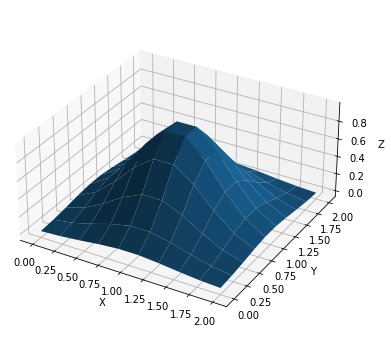

In [11]:
bounds = Box(x=2, y=2, z=1)
height = CenteredGrid(lambda pos: math.exp(-math.vec_squared(pos-1) * 3), 0, bounds['x,y'], x=10, y=10).values
heightmap = geom.Heightmap(height, bounds, max_dist=.1)
show(heightmap)

Again, we can sample directions and distances from the surface.

C:\PhD\phiflow2\PhiML\phiml\backend\_backend.py:1582: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator


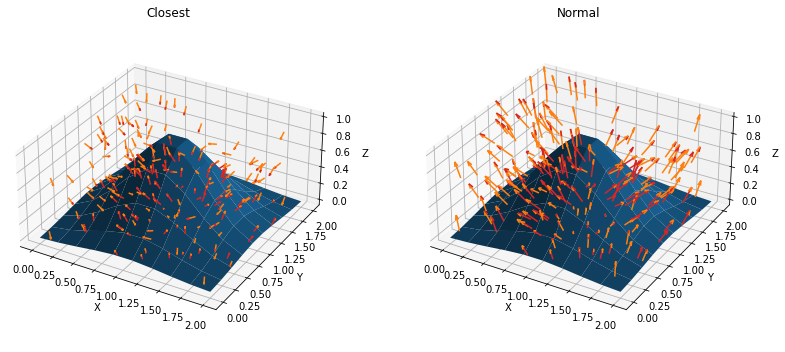

In [12]:
points = bounds.sample_uniform(instance(points=200))
delta, normal, _, face_index = heightmap.approximate_closest_surface(points)
show({'closest': [heightmap, PointCloud(points, .1 * math.vec_normalize(delta))],
      'normal': [heightmap, PointCloud(points, .2 * normal)]}, overlay='list', color=[0, heightmap.lies_inside(points)*2+1])

## Combining Heightmaps

Like all `Geometry` objects, heightmaps can be merged using the [`union`](https://tum-pbs.github.io/PhiFlow/phi/geom/#phi.geom.union) function.

We can use this to create complex obstacles with detailed surfaces on all sides or to create cavities.

C:\PhD\phiflow2\PhiML\phiml\backend\_backend.py:1582: RuntimeWarning: invalid value encountered in divide
  return numerator / denominator
C:\PhD\phiflow2\phi\vis\_matplotlib\_matplotlib_plots.py:161: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure.show()


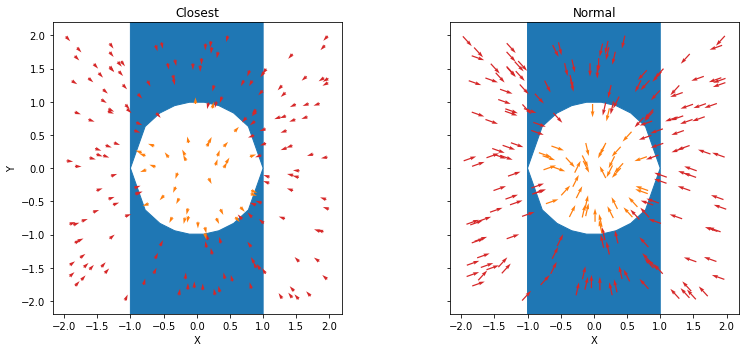

In [3]:
height = (1 - math.linspace(-1, 1, spatial(x=10)) ** 2) ** .5
upper_heightmap = geom.Heightmap(height, Box(x=(-1, 1), y=None), max_dist=.1, fill_below=False, extrapolation=0)
lower_heightmap = geom.Heightmap(-height, Box(x=(-1, 1), y=None), max_dist=.1, fill_below=True, extrapolation=0)
heightmap = union(lower_heightmap, upper_heightmap)

points = Box(x=(-2, 2), y=(-2, 2)).sample_uniform(instance(points=200))
delta, normal, _, face_index = heightmap.approximate_closest_surface(points)
show({'closest': [heightmap, PointCloud(points, .1 * math.vec_normalize(delta))],
      'normal': [heightmap, PointCloud(points, .2 * normal)]}, overlay='list', color=[0, heightmap.lies_inside(points)*2+1])

Here, we set `extrapolation=0` to extend the heightmap beyond its `bounds`.
Consequently, points with *x < -1* or *x > 1* count as inside the mesh and are colored red correspondingly.